# Colorply

## Hands on the Image Formula

#### Definition

The image formula is used to switch from image to ground coordinates system.
For a point $m$ in the image, its representation $M$ in the ground system is linked
to the orientation $R$ of the image, its optical center $S$ and focal length $F$.

$$ m = F - \frac{k^TFR(M - S)}{k^TR(M - S)} $$

In [1]:
import  numpy as np

In [2]:
def image_formula(F, M, R, S):
    """
    Compute the image formula for the point M without distorsion

    Parameters
    ----------
    F : numpy.ndarray
        Position of the autocollimation point in the image coordinate system.
    M : numpy.ndarray
        Position of the point in ground space coordinates.
    R : numpy.ndarray
        Rotation matrix representing the orientation of the image coordinate system
        in the ground space coordinate system.
    S : numpy.ndarray
        Position of the autocollimation point in the ground space coordinate system.

    Returns
    -------
    numpy.ndarray
        Image coordinates of M projected.

    """
    k = np.array([0, 0, 1])
    R_inv = np.linalg.inv(R)
    top = k.dot(F) * R_inv.dot(M - S)
    bottom = k.dot(R_inv).dot(M - S)

    return F - top/bottom

#### Radial Distorsion

The distorsion artefacts \(dr\) is corrected by applying a radial model:

$$ dr = ar^3 + br^5 + cr^7 $$

were $r$ is te distance $d(PPS, m)$
<br>
$a, b, c$ are the distorsion coefficients - computed with a MSE algorithm.

In [3]:
def radial_std(m_image, pps, a, b, c):
    """
    Corrects the postion of the point according 
    to the standard radial distorsion model.

    .. note::
        We use Horner's method to evaluate :math:`ar^2 + br^4 + cr^6`
    
    Parameters
    ----------
    m_image : numpy.ndarray
        Position of the projected point in pixel.
    pps : numpy.ndarray
        Position of the point of 0 distorsion ine the radial_std model.
    a : float
        3rd order coefficient of the distorsion polynomial.
    b : float
        5th order coefficient of the distorsion polynomial.
    c : float
        7th order coefficient of the distorsion polynomial.

    Returns
    -------
    numpy.ndarray
        Corrected point position.

    """
    r = np.linalg.norm(m_image - pps)
    rsquared= r * r

    # Horner's method
    poly = c
    poly = poly * rsquared + b
    poly = poly * rsquared + a
    poly = poly * rsquared
    
    # Correction vector
    dr = poly * (m_image - pps) 
    
    return m_image + dr

In [4]:
def image_formula_corrected(F, M, R, S, pps, a, b, c) :
    """
    Compute the image formula for the point M
    with distorsion.

    .. note::
        See `image_formula` and `radial_std` functions 
        for the full implementation.

    """
    return radial_std(image_formula(F, M, R, S), pps, a, b ,c)

## Multispectral Photogrammetry

The goal here is to reproject all points (from an already computed 1-channel 3D model) into multispectral images, to extract the radiometry visible from this point.

<img src="img/image_formula.gif" width="75%">

In [10]:
def radiometry_projection(M, images_loaded, calibration, mode="avg"):
    """
    This function add to a point M a new channel, computed from the loaded images.
    Therefore, the images should be calibrated in the same reference of your point M.
    Usually, the 3D point M is part of a cloud points.
    The point M is projected in all images that see the point. Then, the radiometry from
    the images channel is added to the point, with different mode.

    .. note:: 
        The default mode `avg` mean all radiometries accesible through `M`.

    Parameters
    ----------
    M : numpy.ndarray
        Position of the point in real space coordinates.
    images_loaded : list of Images
        List of the image loaded. 
        These images need to be referenced in the same system as the point M.
        Usually with MicMac calibrate all the images together.
    calibration : list
        List containing the camera calibration global parameters.
    mode : str, optional
        The way the new radiometry is stacked in the new M channel. 
        This can be with a mean of all radiometry that see the 3D point M. 
        The default is "avg".

    Returns
    -------
    float
        Value of the new channel.

    """
    n = len(images_loaded)
    L = []
    for i in range(n):
        
        img = images_loaded[i]
        size = calibration[3]  # IMAGE size, coordinate i,j != x,y
        data = img.data
        R = img.R
        S = img.S
        F = calibration[0]
        pps = calibration[1]  
        a = calibration[2][0]
        b = calibration[2][1]
        c = calibration[2][2]
        
        m = image_formula_corrected(F, M, R, S, pps, a, b, c)
        mx = int(np.round(m[0]))
        my = int(np.round(m[1]))
        
        if (0 < mx < size[0]) and (0 < my < size[1]):  # because i,j != x,y
            L.append(int(data[my, mx]*0.0038909912109375))
            
    if len(L) != 0:
        return np.mean(L)

## Let's test it

First, we will need data to run the image formula on:

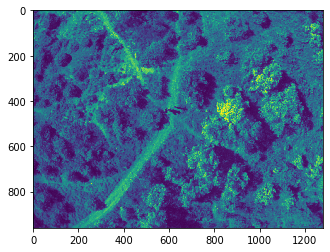

The rotation matrix of the image test/example/ori/image_REG.TIF.xml is:         
[[ 0.99640482  0.08399378 -0.01106709]
 [ 0.08440163 -0.99546705  0.04383748]
 [-0.00733485 -0.04461396 -0.99897737]]

The image's center is:         
[ 38.5396444  873.50388499 736.53965165]

The F point from the camera test/example/calib.xml is:         
[  649.51142664   526.58083869 -1033.21133603]
['638.36727181253309', '505.713078999222773', '0']

The PPS from the camera test/example/calib.xml is:         
[638.36727181 505.713079     0.        ]

The coefficients a, b, c from the camera test/example/calib.xml are:         
[-3.35264752e-07  1.56536235e-13 -4.57835082e-20]


In [11]:
# Plot images
import matplotlib.pyplot as plt

# Read MicMac xml files
from colorply import io


# Images captured on the REG sensor
image_file = "test/example/image_REG.TIF"
#Visualize the image
data = plt.imread(image_file)
plt.imshow(data)
plt.show()

# MicMac calibration files
calibration_file = "test/example/calib.xml"
xmlfile = "test/example/ori/image_REG.TIF.xml"

# 1/ Matrix Rotation
print(f"The rotation matrix of the image {xmlfile} is: \
        \n{io.read_orientation(xmlfile)}") 

# 2/ Center S of the IMG
print(f"\nThe image's center is: \
        \n{io.read_S(xmlfile)}")
      
# 3/ F focale
print(f"\nThe F point from the camera {calibration_file} is: \
        \n{io.read_calib_F(calibration_file)}")

# 4/ PPS 
print(f"\nThe PPS from the camera {calibration_file} is: \
        \n{io.read_calib_PPS(calibration_file)}")

# 5/ Distorsion 
print(f"\nThe coefficients a, b, c from the camera {calibration_file} are: \
        \n{io.read_calib_distorsion(calibration_file)}")

In [16]:
# Define a 3D point in the same coordinates system as the oriented images
M = np.array([2.86285281181335449, 904.19775390625, 686.24530029296875])

# Load all we need (calibration, images, orientation)
calibration_file = "test/data/calibration/Ori-1bande_All_CampariGCP/AutoCal_Foc-4000_Cam-SequoiaSequoia-GRE.xml"
orientation_dir = "test/data/calibration/Ori-1bande_All_CampariGCP"
image_dir = "test/data/images/GRE"
image_ext = "TIF"
channel = "GREEN"

# Read the calibration file
calibration = io.read_calib(calibration_file)

# Load the GREEN images
images_loaded = io.load_images(orientation_dir = orientation_dir,
                               image_dir = image_dir,
                               image_ext = image_ext,
                               channel = channel)

# Projection
radiometry = radiometry_projection(M, images_loaded, calibration, mode="avg")
print(f"Point M: {M}")
print(f"Radiometry added : {radiometry}")

Point M: [  2.86285281 904.19775391 686.24530029]
Radiometry added : 58.0


# Cloud of points

Now that we can ass a new radiometry for one point M, let's do it for multiple points saved in a ply file:

In [22]:
def add_cloud_channel(input_ply, calibration_file, orientation_dir, image_dir, image_ext, channel, mode, output_ply,
                      progress=None):
    """
    All together. Project all points from a ply file.

    Parameters
    ----------
    input_ply : plydata
        The cloud points to add a new channel.
    calibration_file : str
        Path to the MicMac calibration file.
    orientation_dir : str
        Path to the MicMac images orientation directory.
    image_dir : str
        Path to the images with the channel to add.
    image_ext : str
        Images extension (JPG, TIFF, PNG etc.).
    channel : str
        Channe name.
    mode : str
        Way to add the new radiometry to the cloud points.
    output_ply : plydata
        The output cloud points, with the new channel.

    Returns
    -------
    ply
        Return the new ply file, with one extra channel.

    """
    calxml = io.read_calib(calibration_file)
    plydata = io.read_plyfile(input_ply)

    cloud_data = io.plydata_to_array(plydata)
    list_new_radiometry = []
    n = len(cloudData)
    
    images_loaded = io.load_images(orientation_dir, image_dir, image_ext, channel)
    
    for i in range(n):
        M = cloud_data[i, 0:3]  # Collect the XYZ informations from the numpy cloud
        radiometry = radiometry_projection(M, images_loaded, calxml, mode)
        list_new_radiometry.append(radiometry)

    new_cloud = io.write_plydata(plydata, list_new_radiometry, channel, output_ply)

    return new_cloud

## Let's test it

In [23]:
print("\nAdding channel to ply file...")

# Load the 3D model
input_ply = "test/data/result/RVB_GRE.ply"
calibration_file = "test/data/calibration/Ori-1bande_All_CampariGCP/AutoCal_Foc-4000_Cam-SequoiaSequoia-GRE.xml"
orientation_dir = "test/data/calibration/Ori-1bande_All_CampariGCP"
image_dir = "test/data/images/RED"
image_ext = "TIF"
channel = "RED"
mode = "avg"
output_ply = "test_process.ply"

# Project all points from the ply to the images located in `image_dir`
add_cloud_channel(input_ply, 
                  calibration_file, 
                  orientation_dir, 
                  image_dir, 
                  image_ext, 
                  channel, 
                  mode, 
                  output_ply, 
                  progress = None)

print("Channel added")


Adding channel to ply file...
Channel added
